In [2]:
import os
import cv2
import numpy as np

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

from BDRC.inference import ImageInferenceDataset
from BDRC.utils import (
    contour_to_cv,
    infer_batch,
    load_model,
    multi_image_collate_fn,
    show_overlay,
    write_result_parquet
)

print(torch.cuda.is_available())

True


In [2]:
DEVICE = "cuda"
NUM_WORKERS = 4
BATCH_SIZE = 12
class_threshold = 0.85

volume_path = "D:/Datasets/W2PD17487-v2"
dataset = ImageInferenceDataset(volume_path)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=multi_image_collate_fn
)

checkpoint = "Models/BDRC/PhotiLines_new_2024-10-7_21-26/2024-10-7_21-26/segmentation_model.pth"
num_classes = 1
model = load_model(checkpoint, num_classes, DEVICE)

In [ ]:
# single sample
results = []

with torch.no_grad():
    all_tiles, tile_ranges, metas = next(iter(loader))
    result = infer_batch(model, all_tiles, tile_ranges, metas, class_threshold, DEVICE)
    results.append(result)

parquet_out = os.path.join(volume_path, "parquet_out")

for r in results:
    write_result_parquet(r, out_dir=parquet_out)

In [4]:
### run on entire directory
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

class_threshold = 0.85
results = []

with torch.no_grad():
    for all_tiles, tile_ranges, metas in tqdm(loader, total=len(loader)):
        result = infer_batch(model, all_tiles, tile_ranges, metas, class_threshold)
        results.append(result)
    
end.record()
torch.cuda.synchronize()

print(f"Processed {len(dataset)} images")
print(f"Elapsed Inference time: {start.elapsed_time(end) / 1000:.2f}s")

parquet_out = os.path.join(volume_path, "parquet_out")

for _, res in tqdm(enumerate(results), total=len(results)):
    write_result_parquet(res, out_dir=parquet_out)

  0%|          | 0/66 [00:00<?, ?it/s]

Processed 786 images
Elapsed Inference time: 35.95s


  0%|          | 0/66 [00:00<?, ?it/s]

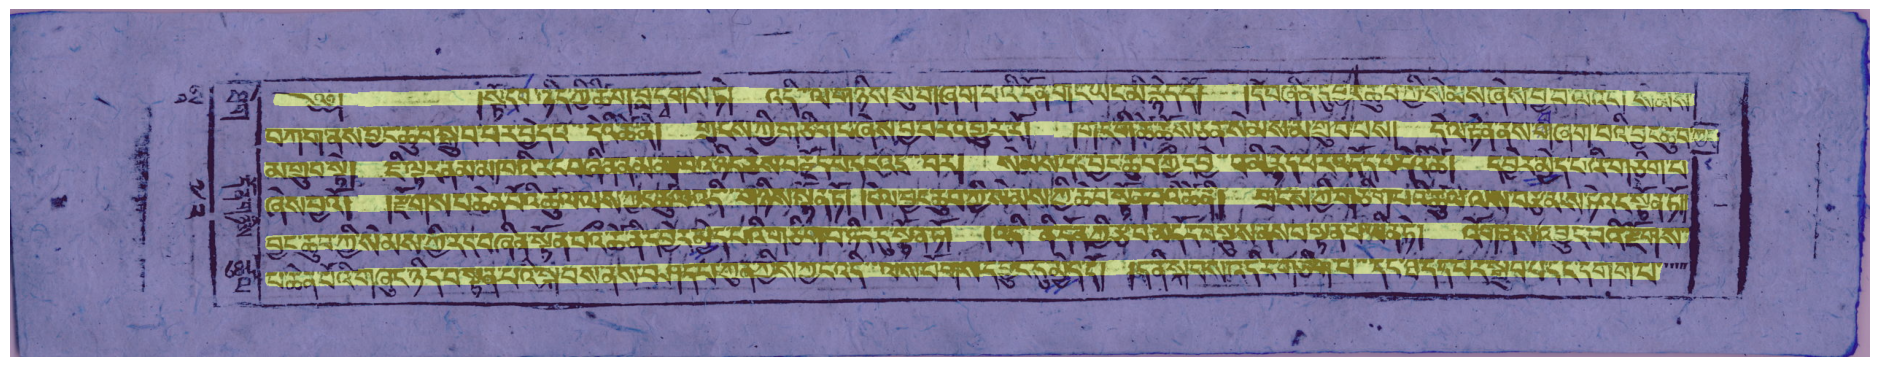

In [9]:
# debug results
res_idx = 12
orig_img_path = os.path.join(volume_path, results[res_idx]["image_name"])
orig_img = cv2.imread(orig_img_path)

prev_mask = np.zeros(shape=(results[res_idx]["image_height"], results[res_idx]["image_width"]), dtype=np.uint8)
contours_cv = [contour_to_cv(c) for c in results[res_idx]["contours"]]

for idx, _ in enumerate(contours_cv):
    cv2.drawContours(prev_mask, contours_cv, contourIdx=idx, color=(255, 255, 255), thickness=-1)

show_overlay(orig_img, prev_mask)